# Mean Reversion Strategies

**Idea 1**
1. Enter when current price is less than -1.0 std relative to sma.
1. Exit when current price is more than 0.0 std relative to sma.
1. Need to check how close are the enter / exit signals


**Idea 2**
1. Enter when short SMA crosses above long SMA.
1. Exit when the price drops below a certain percentage below the long SMA.


**Idea 3**
1. Long when current price is less than -1.0 std relative to sma.
1. Short when current price is more than 1.0 std relative to sma.
1. Exit when price revert back to sma

<br></br>

# Momentum Strategies

**Idea 1**
1. RSI > 70 sell
1. RSI < 30 buy


**Idea 2**
1. Buy when MACD histogram above zero and momentum positive
1. Sell when MACD histogram crosses below zero


**Idea 3**
1. Buy when short ma cross above long ma
1. Sell when short ma cross below long ma

In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io

plt.style.use('ggplot')

In [2]:
class Strategy(bt.Strategy):
    params = (
        ('csv_writer', None),
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.status_code = {
            6: 'Margin',
            7: 'Rejected',
            4: 'Canceled'
        }

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        shares = self.position.size
        print('%s, %s, Cash: %.2f, Portfolio Value: %.2f, Shares Owned: %d' % (dt.isoformat(), txt, cash, value, shares))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        order_action = 'Buy' if order.isbuy() else 'Sell'

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('Buy executed at %.2f' % order.executed.price)
                if self.params.buffer is not None:
                    self.params.buffer.write('%s,Buy,%.2f\n' % (self.datas[0].datetime.datetime(0).isoformat(), order.executed.price))
            elif order.issell():
                self.log('Sell executed at %.2f' % order.executed.price)
                if self.params.buffer is not None:
                    self.params.buffer.write('%s,Sell,%.2f\n' % (self.datas[0].datetime.datetime(0).isoformat(), order.executed.price))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'{order_action} Order Not Executed: {self.status_code[order.status]}')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def stop(self):
        if self.position:
            self.log('Closing position')
            self.close()
            if self.params.buffer is not None:
                self.params.buffer.write('%s,Sell,%.2f\n' % (self.datas[0].datetime.datetime(0).isoformat(), self.dataclose[0]))

    def next(self):
        pass

In [3]:
class Backtest:
    def __init__(self, df, capital = 100 * 1e3):
        self.df = df
        self.buffer = io.StringIO()
        self.capital = capital

    def fit(self, strategy, **kwargs):
        self.buffer.write('Date,Action,Price\n')
        capital = self.capital
        df_result = []
        for day, df_day in self.df.groupby(pd.Grouper(key='datetime', freq='D')):
            if capital < (self.capital * 0.5):
                print('Early stopping')
                break

            if df_day.shape[0] == 0:
                continue
            
            df_day = df_day.copy()
            df_day = df_day[(df_day.index.hour >= 10) & (df_day.index.hour < 12)]
            data = bt.feeds.PandasData(dataname=df_day)
            
            cerebro = bt.Cerebro()
            cerebro.broker.setcash(capital)
            # cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
            # cerebro.addsizer(bt.sizers.AllInSizerInt, percents=100)
            cerebro.adddata(data)
            cerebro.addstrategy(strategy, buffer=self.buffer, total_len=df_day.shape[0], **kwargs)

            print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
            bt_results = cerebro.run()
            print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
            print('\n\n')

            pnl = cerebro.broker.getvalue() - cerebro.broker.startingcash

            df_result.append({
                'datetime': day,
                'portfolio': cerebro.broker.getvalue(),
                'pnl': pnl,
            })
            capital = cerebro.broker.getvalue()
        self.df_result = pd.DataFrame(df_result)
        self.buffer.seek(0)  # Reset buffer position
        self.df_trades = pd.read_csv(self.buffer)

        return self.df_result, self.df_trades
    
    def evaluate(self):
        # supports long only strat
        self.df_trades['Date'] = pd.to_datetime(self.df_trades['Date'])
        sharpes = []
        for day, df_day in self.df_trades.groupby(pd.Grouper(key='Date', freq='D')):
            if df_day.shape[0] == 0:
                continue
            df_day = df_day.copy()
            df_buy = df_day[df_day['Action'] == 'Buy']
            df_sell = df_day[df_day['Action'] == 'Sell']

            returns = []
            for idx, buy in df_buy.iterrows():
                buy_time = buy['Date']
                sell = df_sell[df_sell['Date'] > buy_time].iloc[0]['Price']
                _return = (sell - buy['Price']) / buy['Price']
                if isinstance(_return, float):
                    returns.append(_return)
                else:
                    returns += _return.tolist()

            returns = np.array(returns)
            n_winning_trades = (returns > 0).astype(int).sum()
            n_losing_trades = len(returns) - n_winning_trades
            
            sharpe_ratio = np.mean(returns) / max(0.001, np.std(returns))
            sharpes.append({
                'datetime': day.tz_localize('US/Eastern'), 
                'n_trades': len(returns),
                'n_winning_trades': n_winning_trades,
                'n_losing_trades': n_losing_trades,
                'sharpe_ratio': sharpe_ratio,
            })

        sharpes = pd.DataFrame(sharpes)
        df_result = pd.merge(self.df_result, sharpes, how='left', on='datetime')
        df_result['cum_pnl'] = df_result['pnl'].cumsum()
        df_result.plot(
            x='datetime', y='cum_pnl', 
            title=f'Total PnL: {df_result["cum_pnl"].tolist()[-1]:.2f}, Mean Sharpe Ratio: {df_result["sharpe_ratio"].mean():.2f}', 
            figsize=(8, 6)
        )
        
        return df_result

In [4]:
with pd.HDFStore('./large_files/data2.h5', mode='r') as store:
    df_ = store.get('data/data_imputed_20240226')
df_.info(verbose=3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2522881 entries, 525 to 138563
Data columns (total 10 columns):
 #   Column    Dtype                           
---  ------    -----                           
 0   date      object                          
 1   time      object                          
 2   open      float64                         
 3   high      float64                         
 4   low       float64                         
 5   close     float64                         
 6   volume    int64                           
 7   datetime  datetime64[ns, America/New_York]
 8   day       object                          
 9   month     int64                           
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(2), object(3)
memory usage: 211.7+ MB


In [5]:
df = df_.set_index('datetime', drop=False)
df = df.loc[df.index.year.isin([2021, 2022])]
df = df.loc[df.index.day_of_week == 2]

# Hold

In [6]:
class HoldStrategy(Strategy):
    params = (
        ('buffer', None),
        ('total_len', 120),
    )

    def __init__(self):
        super().__init__()
        self.dataclose = self.datas[0].close

    def next(self):
        if len(self) == 1:
            cash = self.broker.get_cash()
            size = cash // self.dataclose[0]
            self.log(f'Long at {self.dataclose[0]:.2f}')
            self.buy(size=size)

Starting Portfolio Value: 100000.00
2021-01-06T15:00:00, Long at 49.99, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:01:00, Buy executed at 49.98, Cash: 40.00, Portfolio Value: 100160.00, Shares Owned: 2000
2021-01-06T16:59:00, Closing position, Cash: 40.00, Portfolio Value: 101660.00, Shares Owned: 2000
Final Portfolio Value: 101660.00



Starting Portfolio Value: 101660.00
2021-01-13T15:00:00, Long at 52.85, Cash: 101660.00, Portfolio Value: 101660.00, Shares Owned: 0
2021-01-13T15:01:00, Buy executed at 52.85, Cash: 29.45, Portfolio Value: 101602.31, Shares Owned: 1923
2021-01-13T16:59:00, Closing position, Cash: 29.45, Portfolio Value: 102044.60, Shares Owned: 1923
Final Portfolio Value: 102044.60



Starting Portfolio Value: 102044.60
2021-01-20T15:00:00, Long at 53.50, Cash: 102044.60, Portfolio Value: 102044.60, Shares Owned: 0
2021-01-20T15:01:00, Buy executed at 53.50, Cash: 20.10, Portfolio Value: 102006.46, Shares Owned: 1907
2021-01-20T16:59:00

Starting Portfolio Value: 106872.04
2021-04-07T14:00:00, Long at 59.74, Cash: 106872.04, Portfolio Value: 106872.04, Shares Owned: 0
2021-04-07T14:01:00, Buy executed at 59.73, Cash: 74.80, Portfolio Value: 106693.24, Shares Owned: 1788
2021-04-07T15:59:00, Closing position, Cash: 74.80, Portfolio Value: 105191.32, Shares Owned: 1788
Final Portfolio Value: 105191.32



Starting Portfolio Value: 105191.32
2021-04-14T14:00:00, Long at 61.17, Cash: 105191.32, Portfolio Value: 105191.32, Shares Owned: 0
2021-04-14T14:01:00, Buy executed at 61.18, Cash: 22.90, Portfolio Value: 105208.51, Shares Owned: 1719
2021-04-14T15:59:00, Closing position, Cash: 22.90, Portfolio Value: 107907.34, Shares Owned: 1719
Final Portfolio Value: 107907.34



Starting Portfolio Value: 107907.34
2021-04-21T14:00:00, Long at 61.22, Cash: 107907.34, Portfolio Value: 107907.34, Shares Owned: 0
2021-04-21T14:01:00, Buy executed at 61.22, Cash: 37.70, Portfolio Value: 107819.24, Shares Owned: 1762
2021-04-21T15:59:00

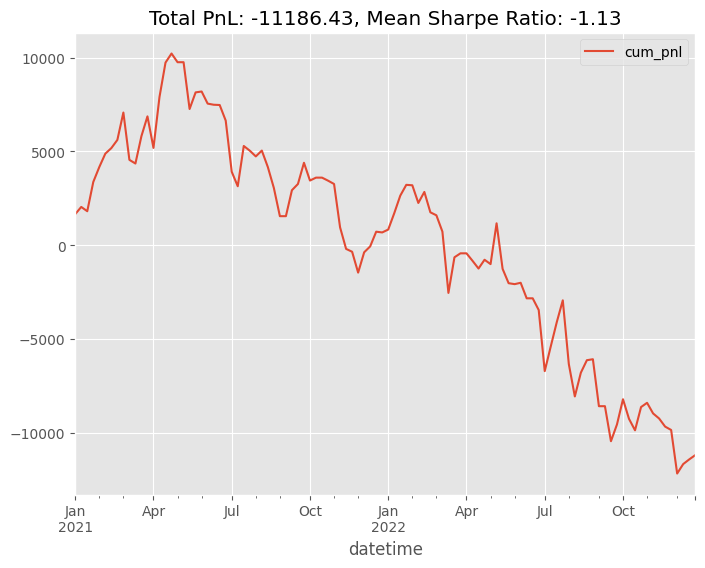

In [7]:
backtest = Backtest(df=df)
result = backtest.fit(HoldStrategy)
res_hold = backtest.evaluate()

## Mean Reversion

### Idea 1

In [8]:
class MeanReversionStrategy(Strategy):
    params = (
        ('period', 15),  # Period for the moving average
        ('up', 0.0),  # Factor for z-score threshold
        ('down', -1.0),
        ('buffer', None),
        ('total_len', 120),
    )

    def __init__(self):
        super().__init__()
        self.dataclose = self.datas[0].close
        self.sma = bt.indicators.SimpleMovingAverage(self.dataclose, period=self.params.period)
        self.std = bt.indicators.StandardDeviation(self.dataclose, period=self.params.period)
        self.z_score = (self.dataclose - self.sma) / self.std

    def next(self):
        if (self.z_score[0] > self.params.up) and self.position:
            self.log(f'Close at {self.dataclose[0]:.2f}')
            self.sell()

        elif self.z_score[0] < self.params.down:
            if (len(self) < self.params.total_len - 1):
                cash = self.broker.get_cash()
                size = cash // self.dataclose[0]
                if size >= 1:
                    self.log(f'Long at {self.dataclose[0]:.2f}')
                    self.buy(size=size)

Starting Portfolio Value: 100000.00
2021-01-06T15:15:00, Long at 49.91, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:16:00, Buy executed at 49.91, Cash: 30.27, Portfolio Value: 100060.09, Shares Owned: 2003
2021-01-06T15:20:00, Close at 49.97, Cash: 30.27, Portfolio Value: 100120.18, Shares Owned: 2003
2021-01-06T15:21:00, Sell executed at 49.97, Cash: 100120.18, Portfolio Value: 100120.18, Shares Owned: 0
2021-01-06T15:21:00, OPERATION PROFIT, GROSS 120.18, NET 120.18, Cash: 100120.18, Portfolio Value: 100120.18, Shares Owned: 0
2021-01-06T15:24:00, Long at 49.87, Cash: 100120.18, Portfolio Value: 100120.18, Shares Owned: 0
2021-01-06T15:25:00, Buy executed at 49.87, Cash: 31.09, Portfolio Value: 100140.25, Shares Owned: 2007
2021-01-06T15:30:00, Close at 50.20, Cash: 31.09, Portfolio Value: 100782.49, Shares Owned: 2007
2021-01-06T15:31:00, Sell executed at 50.21, Cash: 100802.56, Portfolio Value: 100802.56, Shares Owned: 0
2021-01-06T15:31:00, OPERATION

2021-03-24T14:30:00, Long at 59.54, Cash: 102556.37, Portfolio Value: 102556.37, Shares Owned: 0
2021-03-24T14:31:00, Buy executed at 59.54, Cash: 28.49, Portfolio Value: 102900.77, Shares Owned: 1722
2021-03-24T14:31:00, Close at 59.74, Cash: 28.49, Portfolio Value: 102900.77, Shares Owned: 1722
2021-03-24T14:32:00, Sell executed at 59.75, Cash: 102917.99, Portfolio Value: 102917.99, Shares Owned: 0
2021-03-24T14:32:00, OPERATION PROFIT, GROSS 361.62, NET 361.62, Cash: 102917.99, Portfolio Value: 102917.99, Shares Owned: 0
2021-03-24T14:51:00, Long at 59.61, Cash: 102917.99, Portfolio Value: 102917.99, Shares Owned: 0
2021-03-24T14:52:00, Buy executed at 59.61, Cash: 31.13, Portfolio Value: 102935.25, Shares Owned: 1726
2021-03-24T14:58:00, Close at 59.68, Cash: 31.13, Portfolio Value: 103038.81, Shares Owned: 1726
2021-03-24T14:59:00, Sell executed at 59.68, Cash: 103038.81, Portfolio Value: 103038.81, Shares Owned: 0
2021-03-24T14:59:00, OPERATION PROFIT, GROSS 120.82, NET 120.82, C

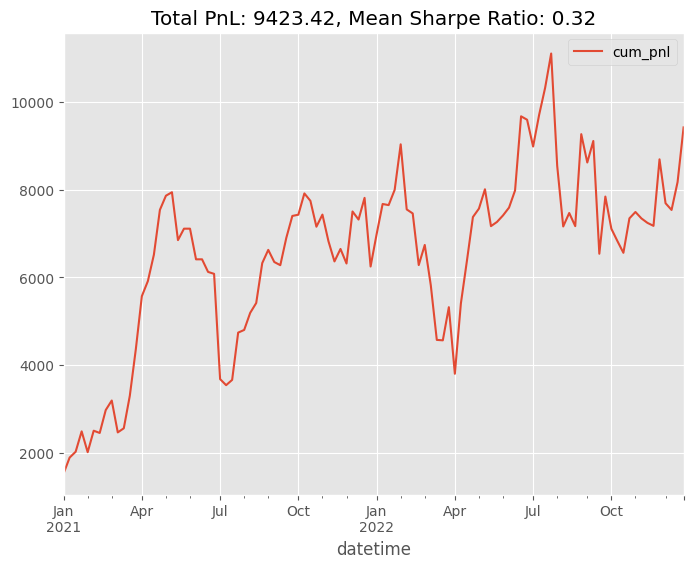

In [9]:
backtest = Backtest(df=df)
result = backtest.fit(MeanReversionStrategy, up=0.0, period=15)
res_mean_reversion = backtest.evaluate()

In [10]:
class SMAMeanReversionStrategy(Strategy):
    params = (
        ('short_period', 15),
        ('long_period', 30),
        ('exit_threshold', 0.02),
        ('buffer', None),
        ('total_len', 120),
    )

    def __init__(self):
        super().__init__()
        self.short_sma = bt.indicators.SimpleMovingAverage(self.dataclose, period=self.params.short_period)
        self.long_sma = bt.indicators.SimpleMovingAverage(self.dataclose, period=self.params.long_period)

    def next(self):
        if self.short_sma > self.long_sma and (len(self) < self.params.total_len - 1):
            # Short SMA crosses above long SMA, enter long position
            cash = self.broker.get_cash()
            price = self.dataclose[0]
            size = cash // price
            if size >= 1:
                self.log(f'Long at {self.dataclose[0]:.2f}')
                self.buy(size=size)

        elif self.dataclose[0] < (self.long_sma * (1 + self.params.exit_threshold)) and self.position.size > 0:
            # Exit if price drops below a certain percentage below the long SMA
            self.log(f'Close at {self.dataclose[0]:.2f}')
            self.close()

Starting Portfolio Value: 100000.00
2021-01-06T15:31:00, Long at 50.17, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:32:00, Buy executed at 50.17, Cash: 11.19, Portfolio Value: 100279.02, Shares Owned: 1993
2021-01-06T15:56:00, Close at 50.22, Cash: 11.19, Portfolio Value: 100099.65, Shares Owned: 1993
2021-01-06T15:57:00, Sell executed at 50.22, Cash: 100099.65, Portfolio Value: 100099.65, Shares Owned: 0
2021-01-06T15:57:00, OPERATION PROFIT, GROSS 99.65, NET 99.65, Cash: 100099.65, Portfolio Value: 100099.65, Shares Owned: 0
2021-01-06T16:12:00, Long at 50.39, Cash: 100099.65, Portfolio Value: 100099.65, Shares Owned: 0
2021-01-06T16:13:00, Buy executed at 50.39, Cash: 25.11, Portfolio Value: 100238.67, Shares Owned: 1986
2021-01-06T16:58:00, Close at 50.82, Cash: 25.11, Portfolio Value: 100953.63, Shares Owned: 1986
2021-01-06T16:59:00, Sell executed at 50.81, Cash: 100933.77, Portfolio Value: 100933.77, Shares Owned: 0
2021-01-06T16:59:00, OPERATION P

Starting Portfolio Value: 101118.82
2021-03-31T14:36:00, Long at 60.34, Cash: 101118.82, Portfolio Value: 101118.82, Shares Owned: 0
2021-03-31T14:37:00, Buy executed at 60.34, Cash: 49.32, Portfolio Value: 101152.32, Shares Owned: 1675
2021-03-31T15:17:00, Close at 60.45, Cash: 49.32, Portfolio Value: 101303.07, Shares Owned: 1675
2021-03-31T15:18:00, Sell executed at 60.45, Cash: 101303.07, Portfolio Value: 101303.07, Shares Owned: 0
2021-03-31T15:18:00, OPERATION PROFIT, GROSS 184.25, NET 184.25, Cash: 101303.07, Portfolio Value: 101303.07, Shares Owned: 0
2021-03-31T15:24:00, Long at 60.65, Cash: 101303.07, Portfolio Value: 101303.07, Shares Owned: 0
2021-03-31T15:25:00, Buy executed at 60.65, Cash: 17.57, Portfolio Value: 101269.67, Shares Owned: 1670
2021-03-31T15:58:00, Close at 61.01, Cash: 17.57, Portfolio Value: 101904.27, Shares Owned: 1670
2021-03-31T15:59:00, Sell executed at 61.01, Cash: 101904.27, Portfolio Value: 101904.27, Shares Owned: 0
2021-03-31T15:59:00, OPERATION

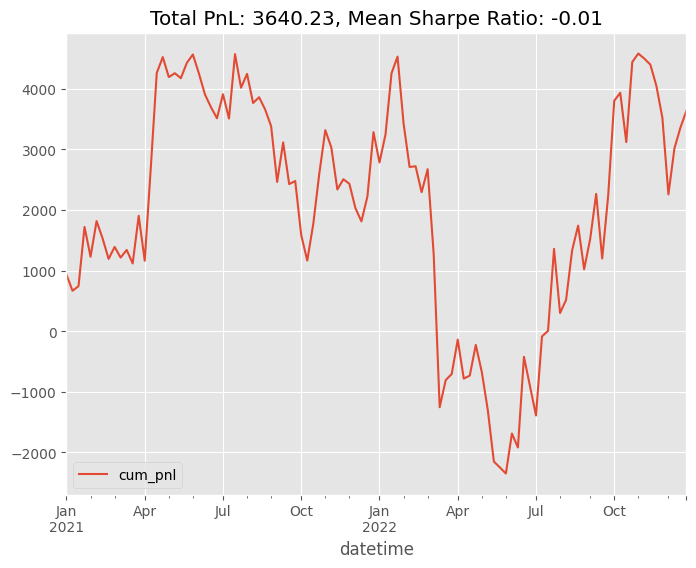

In [11]:
backtest = Backtest(df=df)
result = backtest.fit(SMAMeanReversionStrategy, long_period=30, short_period=10)
res_sma_reversion = backtest.evaluate()

# Momentum

In [12]:
class RsiMomentumStrategy(Strategy):
    params = (
        ('rsi_period', 10),
        ('rsi_oversold', 30),
        ('rsi_overbought', 70),
        ('sma_period', 15),
        ('total_len', None),
        ('buffer', None),
    )

    def __init__(self):
        super().__init__()
        self.rsi = bt.indicators.RSI(period=self.params.rsi_period)
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period)

    def next(self):
        if not self.position:
            if (self.rsi < self.params.rsi_oversold) and (len(self) < self.params.total_len - 1): # and (self.dataclose[0] > self.sma[0]):
                cash = self.broker.get_cash()
                size = cash // self.dataclose[0]
                if size >= 1:
                    self.log(f'Long at {self.dataclose[0]:.2f}')
                    self.buy(size=size)

        elif self.rsi > self.params.rsi_overbought: # or self.dataclose[0] < self.sma:
            self.log(f'Close at {self.dataclose[0]:.2f}')
            self.sell()

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00



Starting Portfolio Value: 100000.00
2021-01-13T16:04:00, Long at 53.10, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-13T16:05:00, Buy Order Not Executed: Rejected, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-13T16:05:00, Long at 53.11, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-13T16:06:00, Buy executed at 53.12, Cash: 28.16, Portfolio Value: 100188.20, Shares Owned: 1882
2021-01-13T16:59:00, Closing position, Cash: 28.16, Portfolio Value: 99868.26, Shares Owned: 1882
Final Portfolio Value: 99868.26



Starting Portfolio Value: 99868.26
2021-01-20T15:25:00, Long at 53.40, Cash: 99868.26, Portfolio Value: 99868.26, Shares Owned: 0
2021-01-20T15:26:00, Buy executed at 53.40, Cash: 10.26, Portfolio Value: 99849.56, Shares Owned: 1870
2021-01-20T16:59:00, Closing position, Cash: 10.26, Portfolio Value: 99830.86, Shares Owned: 1870
Final Portfoli

Starting Portfolio Value: 102884.23
2021-03-10T15:14:00, Long at 64.55, Cash: 102884.23, Portfolio Value: 102884.23, Shares Owned: 0
2021-03-10T15:15:00, Buy executed at 64.55, Cash: 56.08, Portfolio Value: 102868.30, Shares Owned: 1593
2021-03-10T16:59:00, Closing position, Cash: 56.08, Portfolio Value: 101052.28, Shares Owned: 1593
Final Portfolio Value: 101052.28



Starting Portfolio Value: 101052.28
2021-03-17T15:30:00, Long at 64.29, Cash: 101052.28, Portfolio Value: 101052.28, Shares Owned: 0
2021-03-17T15:31:00, Buy executed at 64.30, Cash: 36.98, Portfolio Value: 100989.44, Shares Owned: 1571
2021-03-17T15:59:00, Closing position, Cash: 36.98, Portfolio Value: 100580.98, Shares Owned: 1571
Final Portfolio Value: 100580.98



Starting Portfolio Value: 100580.98
2021-03-24T15:32:00, Long at 59.45, Cash: 100580.98, Portfolio Value: 100580.98, Shares Owned: 0
2021-03-24T15:33:00, Buy executed at 59.45, Cash: 51.03, Portfolio Value: 100361.15, Shares Owned: 1691
2021-03-24T15:46:00

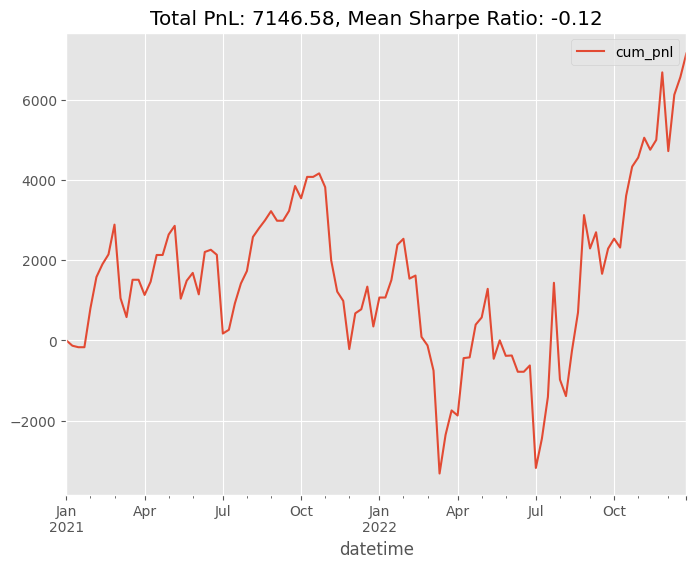

In [13]:
backtest = Backtest(df=df)
result = backtest.fit(RsiMomentumStrategy)
res_rsi = backtest.evaluate()

In [14]:
class MACDMomentumStrategy(Strategy):
    params = (
        ('macd1_period', 10),
        ('macd2_period', 30),
        ('signal_period', 15),
        ('roc_period', 15),
        ('roc_threshold', 0.0),  # Threshold for ROC
        ('total_len', None),
        ('buffer', None),
    )

    def __init__(self):
        super().__init__()
        self.macd = bt.indicators.MACDHisto(
            period_me1=self.params.macd1_period,
            period_me2=self.params.macd2_period,
            period_signal=self.params.signal_period
        )
        self.roc = bt.indicators.ROC(self.data.close, period=self.params.roc_period)

    def next(self):
        if self.position.size == 0:
            if self.macd.lines.histo[0] > 0 and (self.roc > self.params.roc_threshold) and (len(self) < self.params.total_len - 1):
                cash = self.broker.get_cash()
                size = cash // self.dataclose[0]
                if size >= 1:
                    self.log(f'Long at {self.dataclose[0]:.2f}')
                    self.buy(size=size)
        elif self.position.size > 0:
            if self.macd.lines.histo[0] < 0:
                self.log(f'Close at {self.dataclose[0]:.2f}')
                self.close()
        # elif self.position.size < 0:
        #     if self.macd.lines.histo[0] > 0:
        #         self.close()

Starting Portfolio Value: 100000.00
2021-01-06T15:43:00, Long at 50.39, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:44:00, Buy executed at 50.38, Cash: 46.08, Portfolio Value: 100099.20, Shares Owned: 1984
2021-01-06T15:48:00, Close at 50.23, Cash: 46.08, Portfolio Value: 99702.40, Shares Owned: 1984
2021-01-06T15:49:00, Sell executed at 50.22, Cash: 99682.56, Portfolio Value: 99682.56, Shares Owned: 0
2021-01-06T15:49:00, OPERATION PROFIT, GROSS -317.44, NET -317.44, Cash: 99682.56, Portfolio Value: 99682.56, Shares Owned: 0
2021-01-06T16:12:00, Long at 50.39, Cash: 99682.56, Portfolio Value: 99682.56, Shares Owned: 0
2021-01-06T16:13:00, Buy executed at 50.39, Cash: 11.14, Portfolio Value: 99821.02, Shares Owned: 1978
2021-01-06T16:35:00, Close at 50.66, Cash: 11.14, Portfolio Value: 100216.62, Shares Owned: 1978
2021-01-06T16:36:00, Sell executed at 50.66, Cash: 100216.62, Portfolio Value: 100216.62, Shares Owned: 0
2021-01-06T16:36:00, OPERATION PROFI

2021-03-31T14:43:00, Long at 60.46, Cash: 98407.38, Portfolio Value: 98407.38, Shares Owned: 0
2021-03-31T14:44:00, Buy executed at 60.46, Cash: 38.96, Portfolio Value: 98374.84, Shares Owned: 1627
2021-03-31T14:57:00, Close at 60.52, Cash: 38.96, Portfolio Value: 98505.00, Shares Owned: 1627
2021-03-31T14:58:00, Sell executed at 60.52, Cash: 98505.00, Portfolio Value: 98505.00, Shares Owned: 0
2021-03-31T14:58:00, OPERATION PROFIT, GROSS 97.62, NET 97.62, Cash: 98505.00, Portfolio Value: 98505.00, Shares Owned: 0
2021-03-31T15:08:00, Long at 60.69, Cash: 98505.00, Portfolio Value: 98505.00, Shares Owned: 0
2021-03-31T15:09:00, Buy executed at 60.68, Cash: 21.36, Portfolio Value: 98391.39, Shares Owned: 1623
2021-03-31T15:10:00, Close at 60.50, Cash: 21.36, Portfolio Value: 98212.86, Shares Owned: 1623
2021-03-31T15:11:00, Sell executed at 60.51, Cash: 98229.09, Portfolio Value: 98229.09, Shares Owned: 0
2021-03-31T15:11:00, OPERATION PROFIT, GROSS -275.91, NET -275.91, Cash: 98229.09,

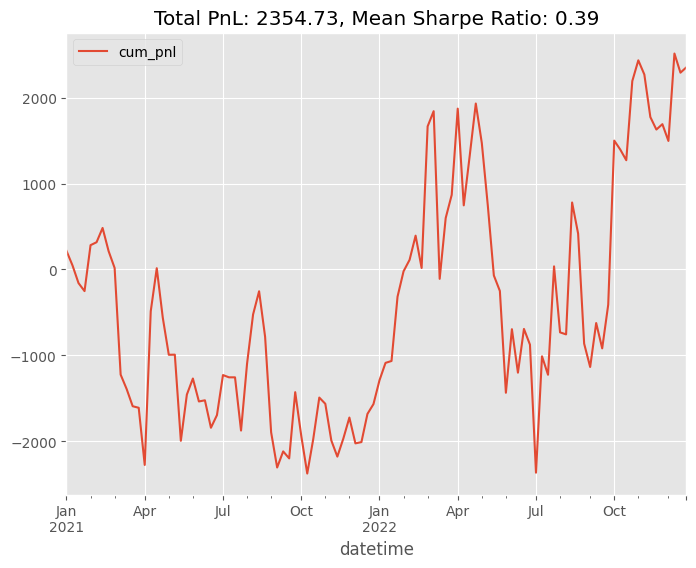

In [15]:
backtest = Backtest(df=df)
result = backtest.fit(MACDMomentumStrategy)
res_macd = backtest.evaluate()

<Axes: >

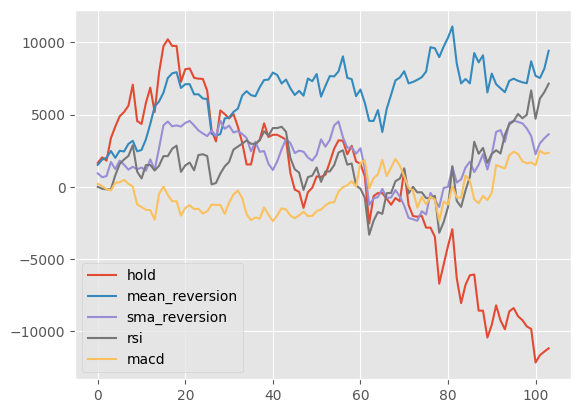

In [16]:
dfs = [res_hold, res_mean_reversion, res_sma_reversion, res_rsi, res_macd]
df_combine = pd.concat([df['cum_pnl'] for df in dfs], axis=1)
df_combine.columns = ['hold', 'mean_reversion', 'sma_reversion', 'rsi', 'macd']
df_combine.plot()

In [17]:
df_combine.corr()

,hold,mean_reversion,sma_reversion,rsi,macd
hold,1.000000,-0.432359,0.198081,-0.159061,-0.519032
mean_reversion,-0.432359,1.000000,0.004900,0.207213,0.012469
sma_reversion,0.198081,0.004900,1.000000,0.628089,-0.009938
rsi,-0.159061,0.207213,0.628089,1.000000,0.221018
macd,-0.519032,0.012469,-0.009938,0.221018,1.000000


# 2023

In [18]:
df = df_.set_index('datetime', drop=False)
df = df.loc[df.index.year.isin([2023])]
df = df.loc[df.index.day_of_week == 2]

Starting Portfolio Value: 100000.00
2023-01-04T15:00:00, Long at 74.22, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2023-01-04T15:01:00, Buy executed at 74.21, Cash: 39.13, Portfolio Value: 99946.12, Shares Owned: 1347
2023-01-04T16:59:00, Closing position, Cash: 39.13, Portfolio Value: 99030.16, Shares Owned: 1347
Final Portfolio Value: 99030.16



Starting Portfolio Value: 99030.16
2023-01-11T15:00:00, Long at 76.37, Cash: 99030.16, Portfolio Value: 99030.16, Shares Owned: 0
2023-01-11T15:01:00, Buy executed at 76.37, Cash: 54.64, Portfolio Value: 99094.96, Shares Owned: 1296
2023-01-11T16:59:00, Closing position, Cash: 54.64, Portfolio Value: 100183.60, Shares Owned: 1296
Final Portfolio Value: 100183.60



Starting Portfolio Value: 100183.60
2023-01-18T15:00:00, Long at 82.26, Cash: 100183.60, Portfolio Value: 100183.60, Shares Owned: 0
2023-01-18T15:01:00, Buy executed at 82.25, Cash: 85.35, Portfolio Value: 100159.26, Shares Owned: 1217
2023-01-18T16:59:00, Closi

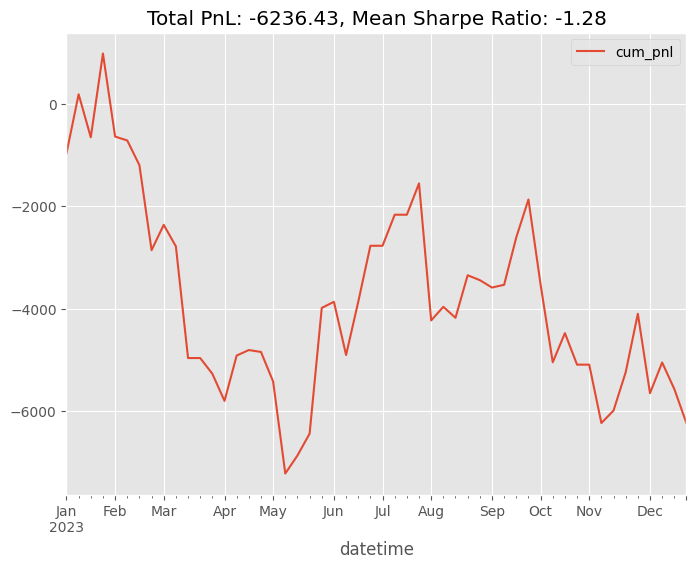

In [19]:
backtest = Backtest(df=df)
result = backtest.fit(HoldStrategy)
res_hold = backtest.evaluate()

Starting Portfolio Value: 100000.00
2023-01-04T15:14:00, Long at 73.63, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2023-01-04T15:15:00, Buy Order Not Executed: Rejected, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2023-01-04T15:15:00, Long at 73.66, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2023-01-04T15:16:00, Buy executed at 73.67, Cash: 29.81, Portfolio Value: 100013.57, Shares Owned: 1357
2023-01-04T15:22:00, Close at 73.74, Cash: 29.81, Portfolio Value: 100094.99, Shares Owned: 1357
2023-01-04T15:23:00, Sell executed at 73.73, Cash: 100081.42, Portfolio Value: 100081.42, Shares Owned: 0
2023-01-04T15:23:00, OPERATION PROFIT, GROSS 81.42, NET 81.42, Cash: 100081.42, Portfolio Value: 100081.42, Shares Owned: 0
2023-01-04T15:35:00, Long at 73.60, Cash: 100081.42, Portfolio Value: 100081.42, Shares Owned: 0
2023-01-04T15:36:00, Buy executed at 73.58, Cash: 86.20, Portfolio Value: 100230.91, Shares Owned: 1359
2023-01-04T15:40:00, L

2023-03-22T14:17:00, Long at 70.02, Cash: 97150.23, Portfolio Value: 97150.23, Shares Owned: 0
2023-03-22T14:18:00, Buy executed at 70.02, Cash: 32.49, Portfolio Value: 97053.14, Shares Owned: 1387
2023-03-22T14:37:00, Close at 69.77, Cash: 32.49, Portfolio Value: 96803.48, Shares Owned: 1387
2023-03-22T14:38:00, Sell executed at 69.77, Cash: 96803.48, Portfolio Value: 96803.48, Shares Owned: 0
2023-03-22T14:38:00, OPERATION PROFIT, GROSS -346.75, NET -346.75, Cash: 96803.48, Portfolio Value: 96803.48, Shares Owned: 0
2023-03-22T14:39:00, Long at 69.55, Cash: 96803.48, Portfolio Value: 96803.48, Shares Owned: 0
2023-03-22T14:40:00, Buy executed at 69.55, Cash: 59.43, Portfolio Value: 96817.39, Shares Owned: 1391
2023-03-22T14:47:00, Close at 69.61, Cash: 59.43, Portfolio Value: 96886.94, Shares Owned: 1391
2023-03-22T14:48:00, Sell executed at 69.60, Cash: 96873.03, Portfolio Value: 96873.03, Shares Owned: 0
2023-03-22T14:48:00, OPERATION PROFIT, GROSS 69.55, NET 69.55, Cash: 96873.03,

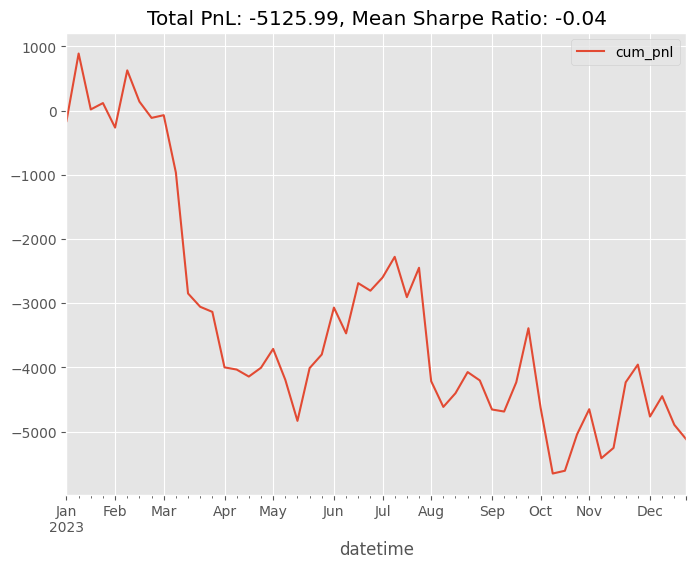

In [20]:
backtest = Backtest(df=df)
result = backtest.fit(MeanReversionStrategy, up=0.0, period=15)
res_mean_reversion = backtest.evaluate()

Starting Portfolio Value: 100000.00
2023-01-04T15:33:00, Long at 73.76, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2023-01-04T15:34:00, Buy executed at 73.76, Cash: 55.20, Portfolio Value: 99945.80, Shares Owned: 1355
2023-01-04T15:38:00, Close at 73.74, Cash: 55.20, Portfolio Value: 99972.90, Shares Owned: 1355
2023-01-04T15:39:00, Sell executed at 73.75, Cash: 99986.45, Portfolio Value: 99986.45, Shares Owned: 0
2023-01-04T15:39:00, OPERATION PROFIT, GROSS -13.55, NET -13.55, Cash: 99986.45, Portfolio Value: 99986.45, Shares Owned: 0
2023-01-04T16:13:00, Long at 73.76, Cash: 99986.45, Portfolio Value: 99986.45, Shares Owned: 0
2023-01-04T16:14:00, Buy executed at 73.76, Cash: 41.65, Portfolio Value: 100027.10, Shares Owned: 1355
2023-01-04T16:26:00, Close at 73.21, Cash: 41.65, Portfolio Value: 99241.20, Shares Owned: 1355
2023-01-04T16:27:00, Sell executed at 73.20, Cash: 99227.65, Portfolio Value: 99227.65, Shares Owned: 0
2023-01-04T16:27:00, OPERATION PROFIT, GR

Starting Portfolio Value: 96442.29
2023-03-29T14:35:00, Long at 74.05, Cash: 96442.29, Portfolio Value: 96442.29, Shares Owned: 0
2023-03-29T14:36:00, Buy executed at 74.05, Cash: 29.19, Portfolio Value: 96468.33, Shares Owned: 1302
2023-03-29T14:48:00, Close at 73.94, Cash: 29.19, Portfolio Value: 96299.07, Shares Owned: 1302
2023-03-29T14:49:00, Sell executed at 73.94, Cash: 96299.07, Portfolio Value: 96299.07, Shares Owned: 0
2023-03-29T14:49:00, OPERATION PROFIT, GROSS -143.22, NET -143.22, Cash: 96299.07, Portfolio Value: 96299.07, Shares Owned: 0
2023-03-29T14:59:00, Long at 74.06, Cash: 96299.07, Portfolio Value: 96299.07, Shares Owned: 0
2023-03-29T15:00:00, Buy executed at 74.07, Cash: 8.07, Portfolio Value: 96273.07, Shares Owned: 1300
2023-03-29T15:14:00, Close at 74.01, Cash: 8.07, Portfolio Value: 96221.07, Shares Owned: 1300
2023-03-29T15:15:00, Sell executed at 74.00, Cash: 96208.07, Portfolio Value: 96208.07, Shares Owned: 0
2023-03-29T15:15:00, OPERATION PROFIT, GROSS 

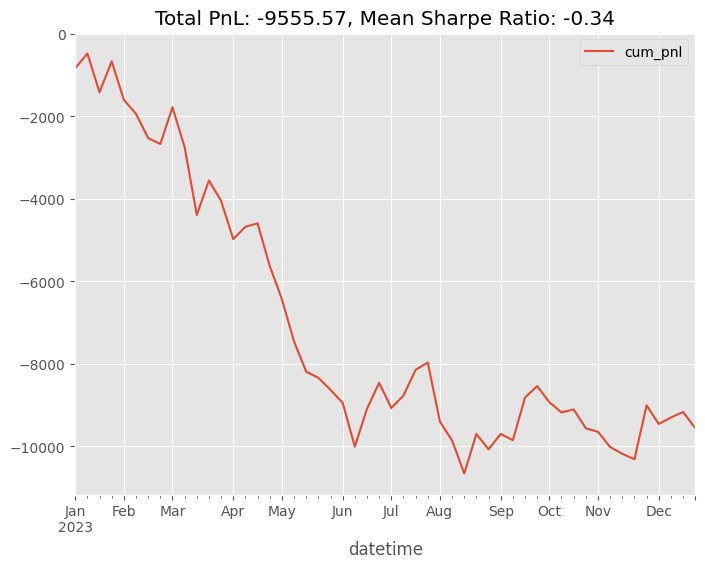

In [21]:
backtest = Backtest(df=df)
result = backtest.fit(SMAMeanReversionStrategy, long_period=30, short_period=10)
res_sma_reversion = backtest.evaluate()

Starting Portfolio Value: 100000.00
2023-01-04T15:14:00, Long at 73.63, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2023-01-04T15:15:00, Buy Order Not Executed: Rejected, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2023-01-04T15:15:00, Long at 73.66, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2023-01-04T15:16:00, Buy executed at 73.67, Cash: 29.81, Portfolio Value: 100013.57, Shares Owned: 1357
2023-01-04T16:12:00, Close at 73.73, Cash: 29.81, Portfolio Value: 100081.42, Shares Owned: 1357
2023-01-04T16:13:00, Sell executed at 73.74, Cash: 100094.99, Portfolio Value: 100094.99, Shares Owned: 0
2023-01-04T16:13:00, OPERATION PROFIT, GROSS 94.99, NET 94.99, Cash: 100094.99, Portfolio Value: 100094.99, Shares Owned: 0
Final Portfolio Value: 100094.99



Starting Portfolio Value: 100094.99
2023-01-11T15:30:00, Long at 75.80, Cash: 100094.99, Portfolio Value: 100094.99, Shares Owned: 0
2023-01-11T15:31:00, Buy executed at 75.80, Cash: 38.9

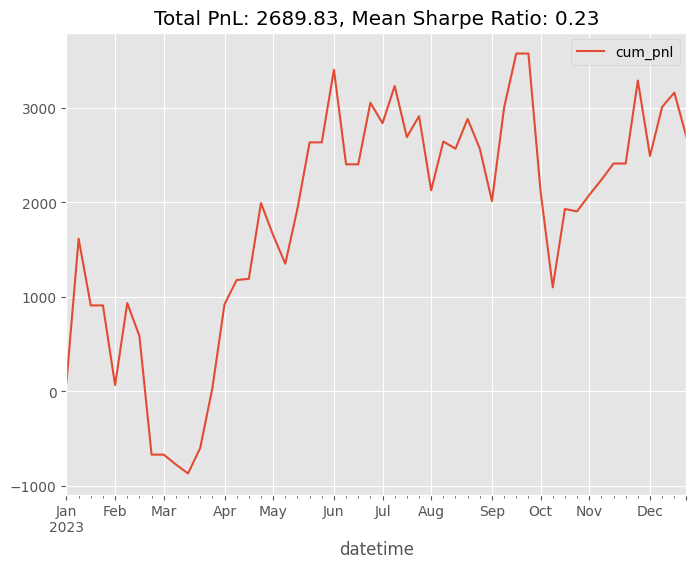

In [22]:
backtest = Backtest(df=df)
result = backtest.fit(RsiMomentumStrategy)
res_rsi = backtest.evaluate()

Starting Portfolio Value: 100000.00
2023-01-04T16:08:00, Long at 73.34, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2023-01-04T16:09:00, Buy executed at 73.34, Cash: 37.58, Portfolio Value: 100299.86, Shares Owned: 1363
2023-01-04T16:21:00, Close at 73.25, Cash: 37.58, Portfolio Value: 99877.33, Shares Owned: 1363
2023-01-04T16:22:00, Sell executed at 73.25, Cash: 99877.33, Portfolio Value: 99877.33, Shares Owned: 0
2023-01-04T16:22:00, OPERATION PROFIT, GROSS -122.67, NET -122.67, Cash: 99877.33, Portfolio Value: 99877.33, Shares Owned: 0
2023-01-04T16:34:00, Long at 73.49, Cash: 99877.33, Portfolio Value: 99877.33, Shares Owned: 0
2023-01-04T16:35:00, Buy executed at 73.49, Cash: 4.42, Portfolio Value: 99700.66, Shares Owned: 1359
2023-01-04T16:57:00, Close at 73.34, Cash: 4.42, Portfolio Value: 99673.48, Shares Owned: 1359
2023-01-04T16:58:00, Sell executed at 73.35, Cash: 99687.07, Portfolio Value: 99687.07, Shares Owned: 0
2023-01-04T16:58:00, OPERATION PROFIT, GR

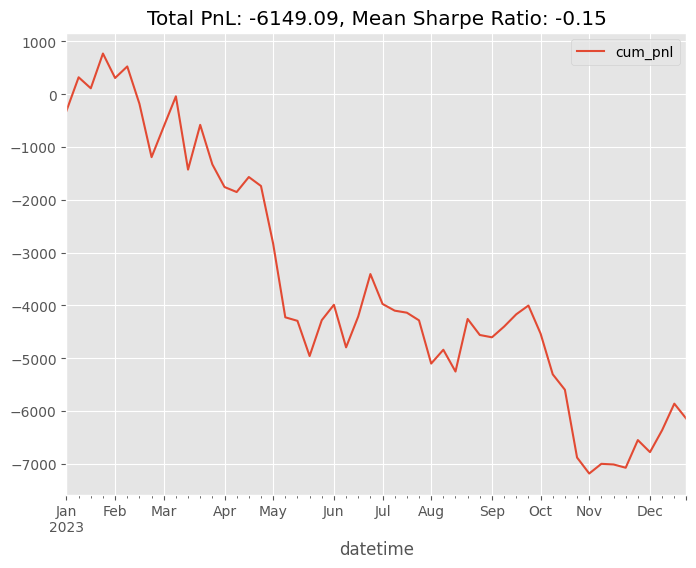

In [23]:
backtest = Backtest(df=df)
result = backtest.fit(MACDMomentumStrategy)
res_macd = backtest.evaluate()